# GTEx eQTL detection: trans- pipeline for consortium paper

This notebook summarizes the trans- associations that we draw from the GTEx data, for the consortium paper.

All the relevant code for this pipeline can be viewed at:

https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/eqtls/trans/gtex/consortium/

The table of contents for this notebook:

## 1. All-by-all trans associations, with PEER increments of 5

### 1.1 MatrixEQTL scripts for all-by-all trans tests

### 1.2 FDR calibration across the whole dataset

### 1.3 Cross-mapping filter and final eQTL list

### 1.4 Summary of the final set of trans-eQTLs at FDR 0.1

## 2. Additional trans-lists from MatrixEQTL

### 2.1 Intrachromosomal QTLs

### 2.2 Three subsetting methods: cis-eQTLs, trait-associated SNPs (GWAS hits), and PLINK-pruned set based on LD

### 2.3 Summary of the final set of trans-eQTLs at FDR 0.1

## 3. Results gallery

### Trans-eQTLs in 9q22 locus in thyroid

## 4. Additional results for the revision

### 4.1 Varying the number of PEER factors in trans runs

### 4.2 Association mapping with Genotype PCs and PEER factors

### 4.3 Varying the FDR threshold for expanded analysis of trans hits

### 4.4 AA/EA segregation runs for the trans hits

### 4.5 MR - Causal inference framework on GTEx data

## 1. All-by-all trans associations

The simplest way of looking for trans-eQTLs are to just plug in all gene expression values and all SNPs and looking for associations. However, we need to be more careful for trans- tests to make sure that we are properly filtering out false positives, since the weaker signal and higher number of tests can lead to mapping artifacts vastly overestimating the strength of association.

We are going to follow these steps:

1. Filter genes based on mappability - we use an arbitrary threshold of 0.8.
2. Filter SNPs based on RepeatMasker (not belonging to any annotated repeat regions) - this part covered in the Genotype notebook.
3. Run MatrixEQTL, while making sure to filter snps based on tissue-specific MAF of 0.05.
4. Cross out any SNP-gene pairs for which there is potential cross-mapping - This notebook will get into more detail about this later.

Here are some highlights of our pipeline:

- We used GTEx v6p release, since this release has fixed some problems with expression quantification in regions where mapping is ambiguous.

- Gene mappability, which in this case is the measure of how much ambiguity there exists across exons and UTRs in a gene in terms of read mapping, can be found in:

<code>/tigress/BEE/RNAseq/Data/Resources/annotations/avg_mappability_Exon_UTR.txt</code>

- Repeatmasker raw data, which annotates all repeat regions in human genome version hg19 (including SINEs, LINEs, transposons, etc.), can be found in :

<code>/tigress/BEE/RNAseq/Data/Resources/RepeatMasker/</code>

- MatrixEQTL runs, in addition to the tissue-specific PEER factors, also include a set of 5 covariates: First 3 genotype PCs, sex and genotyping platform. Either sex or genotyping platform is not included if there is only one type (i.e. testis, cervix, etc.)

- The Cross-mapping filtering part comes from:

<code>/tigress/BEE/RNAseq/Data/Resources/annotations/pairwise_conflict.txt</code>

This file has 23727385 pairs that are potentially cross-mapping

The reason step point 4 belongs after running MatrixEQTL is because if we were to apply this filter beforehand, we will need a gene-specific snp set for our tests, significantly increasing the number of iterations and severely slowing our pipeline as a consequence.

As it can be seen, we put a lot of filters in place to make sure that we get a very conservative set of trans- calls, in contrast to the cis- call that have been made both by the consortium and by us independently.

### 1.1 MatrixEQTL scripts for all-by-all trans tests

- More details about the trans-eQTL mapping procedure:

#### Gene set

Used the cis-eQTL analysis gene set shared by Joe:

<code>
In della: /tigress/BEE/RNAseq/Data/Resources/annotations/gtex.v6p.genes.with.without.cis.eqtls.tested.txt

In hhpc: /scratch0/battle-fs1/heyuan/trans/response_to_review/trans-eQTLs/gene_sets/gtex.v6p.genes.with.without.cis.eqtls.tested.txt

Number of genes : 24411
Number of ‘protein-coding’ genes : 18394
Number of ‘lincRNA’ genes : 6017
</code>

#### SNP set

Genotype file location - 
<code>
In della: /tigress/BEE/RNAseq/Data/Genotype/gtex/imputed_genotypes/allelic_dosage/continuous/

In hhpc: /scratch0/battle-fs1/heyuan/trans/data/Genotype_continuous/
</code>

They were obtained by reading in dosage values directly from the consortium genotype files (they have been corrected from the first-pass) - 
<code>
GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs.vcf.gz
</code>

#### New Trans-eQTL mapping pipeline

#### Step 1: Run MatrixEQTL, for all-by-all trans pairs, with incremental PEER correction.

#### Brief summary of the mapping procedure :

- Read in all gene expression matrix, genotype matrix, gene positions, and SNP positions.
- Filter genes by mappability cutoff of 0.8.
- Filter SNPs by tissue-specific MAF of 0.05.
- Read in covariates and prepare covariate matrices with number of PEER factors in increments of 5 (genotype PCs 1-3, sex and genotype platform are included in all cases).
- Run Matrix eQTL
- Output trans-eQTL mapping at p-value threshold of 1e-5
- Note that separation of joint, protein-coding and lincRNA sets doesn’t happen here - it happens in the FDR calibration step.

Given the expression matrices, we can run the trans-eQTL mapping script:

In [ ]:
%%bash
export proj='/tigress/BEE/RNAseq'
# gtex gct
python $proj/Scripts/eqtls/trans/gtex/consortium/trans_matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_v6p_consortium_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
trans_matrix_eqtl_PEER_increments_final.R 2.5e8 20 30

After running the above script, we have raw output files in Della, located at:

<code>
/tigress/BEE/RNAseq/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments
Total data disk usage: ~14G
</code>

#### Outputs : Number of genes tested, SNPs tested, Total Number of tests, P-value histograms, eQTL summary statistics below p-value threshold of 1e-5


### 1.2 FDR calibration across the whole dataset

After running the MatrixEQTL for all SNP-gene pairs, we collect the overall statistics across parallel runs, calibrate FDR based on joint, protein-coding and lincRNA test sets and then write the list of significant eQTLs.

#### Brief summary of the FDR calibration procedure :

- Read in the tissue-specific expression and annotation file for categorizing genes into ‘protein-coding’ and ‘lincRNA’ sets.
- Read in all data files from parallel runs of Matrix eQTL, and accumulate the following numbers: Number of tests, P-value histograms (in bins of 0.01), and eQTL summary stats.
- Separate the gene set into ‘protein-coding’ and ‘lincRNA’, and calculate the number of tests accordingly for them
- Run Benjamini-Hochberg on joint, protein-coding and lineRNA test sets with the respective number of tests
- Output the list with updated FDR values by tissue and by test set


In [ ]:
%%bash
# gtex gct
python $proj/Scripts/eqtls/trans/gtex/consortium/MatrixEQTL_FDR_control_wrapper_PEER_increments.py \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/ \
all-by-all-PEER-increments MatrixEQTL_FDR_control_PEER_increments_final.R \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/tissue_list.txt

Location of resulting eQTL lists in Della :

<code>
/tigress/BEE/RNAseq/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/eqtl_list/
Total data disk usage: ~9.6G
</code>

#### Outputs : Three sets of summary statistics - joint, protein-coding, and lincRNA trans-eQTL sets


### 1.3 Cross-mapping filter and final eQTL list

#### Brief summary of the procedure : 

- Read in the cross-mapping gene pair reference.
- Check, for each SNP, whether there is a gene within a distance threshold (100kb is used) that has potential cross-mapping with the target gene, and if it does, remove from the list.
- Output at FDR threshold of 0.1, and also output at p-value threshold of 1e-5, only for the full PEER-factor corrected, joint analysis set (for Ben’s cross-tissue analysis). Also output a list of trans-eQTLs detected in tests with low number of PEER factors but not in full set of PEER factors (for Princy’s analysis).

Note: tissue_list.txt file has the set of 44 tissues that are being analyzed for the consortium - you can alter this file to change the set of tissues to output the final list.

In [ ]:
%%bash
# gtex gct
python $proj/Scripts/eqtls/trans/gtex/consortium/Final_trans_list_wrapper.py \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/ \
1e5 /Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/tissue_list.txt

Location of resulting eQTL lists in Della :

<code>
/tigress/BEE/RNAseq/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/eqtl_list_post_crossmapping/
Total data disk usage: 58M, when only eQTLs with FDR < 0.5 are saved.
</code>

### 1.4 Summary of the final set of trans-eQTLs at FDR 0.1

<code>
Number of trans-eQTLs at FDR 0.1 : 673
(510 at FDR 0.05)
Number of trans-eGenes at FDR 0.1 : 93
(50 at FDR 0.05)
Number of unique trans-eVariants at FDR 0.1 : 602
(441 at FDR 0.05)
Number of tissues at FDR 0.1 : 16
(also 16 in the previous iteration - We have 12 at FDR 0.05)
</code>


- Number of new trans-eQTLs not previously detected: 115 - Note that the most significant set of additions are in testis - the result is mostly unchanged in other tissues.
- Number of trans-eQTLs from previous iteration that are not included: 34.

#### trans-eQTLs from previous iteration ("preprint set") that are no longer in the joint set:

<code>
cellstransformedfibroblasts_ENSG00000162913.9_rs60307965 
colontransverse_ENSG00000049246.10_rs2028275 
muscleskeletal_ENSG00000206384.6_rs75674648 
nervetibial_ENSG00000117410.9_rs6007631 
skinsunexposedlowerleg_ENSG00000175634.10_rs76942982 
skinsunexposedlowerleg_ENSG00000158201.5_rs7746836 
skinsunexposedlowerleg_ENSG00000166321.9_rs7683255 
skinsunexposedlowerleg_ENSG00000048140.13_rs9948985 
skinsunexposedlowerleg_ENSG00000188517.10_rs9511151 
skinsunexposedlowerleg_ENSG00000188517.10_rs9507287 
testis_ENSG00000170454.5_rs192710288 
thyroid_ENSG00000211789.2_rs12342436 
thyroid_ENSG00000187608.5_rs4142913 
thyroid_ENSG00000187608.5_rs4142914 
thyroid_ENSG00000106123.7_rs4896168 
thyroid_ENSG00000132470.9_rs16908638 
thyroid_ENSG00000187608.5_rs10517676 
thyroid_ENSG00000187608.5_rs10023422 
thyroid_ENSG00000112379.8_rs2120262 
thyroid_ENSG00000132470.9_rs12777352 
thyroid_ENSG00000108826.11_rs2665917 
thyroid_ENSG00000162482.4_rs7786395 
thyroid_ENSG00000150977.9_rs55914535 
thyroid_ENSG00000112379.8_rs894672 
thyroid_ENSG00000112379.8_rs7848950 
thyroid_ENSG00000112379.8_rs1348386 
thyroid_ENSG00000112379.8_rs7849497 
thyroid_ENSG00000112379.8_rs3021523 
thyroid_ENSG00000112379.8_rs7046645 
thyroid_ENSG00000189043.5_rs12593758 
thyroid_ENSG00000112379.8_rs10983975 
thyroid_ENSG00000112379.8_rs7024345 
thyroid_ENSG00000112379.8_rs6478423 
thyroid_ENSG00000189043.5_rs11635416
</code>

#### Number of trans-eQTLs per tissue :

<code>
"adiposesubcutaneous" 7
"adrenalgland" 1
"arteryaorta" 1
"brainputamenbasalganglia" 11
"cellstransformedfibroblasts" 10
"colontransverse" 10
"esophagusmucosa" 11
"lung" 2
"muscleskeletal" 43
"pancreas" 12
"skinnotsunexposedsuprapubic" 1
"skinsunexposedlowerleg" 16
"testis" 290
"thyroid" 229
"vagina" 27
"wholeblood" 2
</code>

## 2. Additional trans-lists from MatrixEQTL

In this section, we obtain additional set of QTLs for various additional analysis that helps us characterizes the GTEx  eQTLs. Namely, we obtain the intrachromosomal trans-eQTLs (> 5MB from the TSS), and 3 types of subsetting for the variant set:

- cis-eQTLs, as identified by the consortium:

<code>/tigress/BEE/eQTLs/Data/References/GTEx/v6p_fastQTL_FOR_QC_ONLY/*_Analysis.v6p.FOR_QC_ONLY.snpgenes.txt.gz</code>

- trait-associated SNPs (GWAS hits):

<code>/tigress/BEE/RNAseq/Data/Resources/annotations/gwas_catalog_v1.0.1-associations_e84_r2016-06-12.tsv</code>

- PLINK-pruned set based on LD, using the parameter set:

<code>/tigress/BEE/tools/plink --bfile /tigress/BEE/gtex/data/genotype/imputed_genotypes/plink/GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf05_HWEp1E6_dbSNPIDs.chr1 --indep 50 5 2

mv plink.prune.in chr1.txt
</code>
repeated from chrs 1 to 22 and the list saved at:
<code>/tigress/BEE/RNAseq/Data/Genotype/gtex/imputed_genotypes/allelic_dosage/continuous/subset_SNPs/ld-subset/master/</code>

### 2.1 Intrachromosomal QTLs

In this run, we take the set of SNP-gene pairs that are distant (>5MB from the TSS), and see if the amount of trans- signal is significantly different from the cis- and trans- eQTL signal. The following scripts are comparable to the steps described in sections 1.1, 1.2 and 1.3:

In [ ]:
%%bash
#mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal

python $proj/Scripts/eqtls/trans/gtex/consortium/trans_matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_v6p_consortium_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
trans_matrix_eqtl_intrachromosomal_final.R 5e6 1 6

python $proj/Scripts/eqtls/trans/gtex/consortium/MatrixEQTL_FDR_control_wrapper.py \
/Output/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/intrachromosomal/ \
intrachromosomal MatrixEQTL_FDR_control_intrachromosomal_final.R \
all

Rscript $proj/Scripts/eqtls/trans/gtex/consortium/Final_trans_list_intrachrom.R \
$proj/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/intrachromosomal/ 1e5

Final list of intrachromosomal eQTLs post cross-mapping:

### 2.2 Three subsetting methods: cis-eQTLs, trait-associated SNPs (GWAS hits), and PLINK-pruned set based on LD

For the consortium paper, we carry out three types of subsetting runs: top cis-SNPs, GWAS SNPs, and LD-pruned SNPs. The following scripts are also comparable to the steps 1.1, 1.2 and 1.3.

In [ ]:
%%bash
#mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/subset_runs

python $proj/Scripts/eqtls/trans/gtex/consortium/trans_matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_v6p_consortium_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/subset_runs/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/subset_runs/ \
trans_matrix_eqtl_subset_runs_final.R 2.5e8 1 22

Rscript $proj/Scripts/eqtls/trans/gtex/consortium/MatrixEQTL_FDR_control_subset_runs_final.R \
$proj/Output/trans-mapping/gtex/MatrixEQTL/subset_runs/ \
$proj/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/subset_runs/

Rscript $proj/Scripts/eqtls/trans/gtex/consortium/Final_trans_list_subset.R \
$proj/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/intrachromosomal/ 1e5


Final list of intrachromosomal eQTLs post cross-mapping:

### 2.3 Summary of the final set of trans-eQTLs at FDR 0.1


In [ ]:
%%bash

mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/boxplots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/corrected_boxplots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/partial_qq_plots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/pvalue_histograms
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/pileup_plots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/run_summary
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/eqtl_list

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_gwas_subset.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt gtex_gct_v6p \
/tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ \
1 0 2.5e8 1



### 2.3 Cross-mapping filter and Collection of relevant plots 

In [ ]:
%%bash
/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/trans_eqtl_final_list_boxplot.R /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all/gtex_gct_v6p/"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/trans_eqtl_final_list_boxplot.R /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/cis-best-subset/gtex_gct_v6p/"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/trans_eqtl_final_list_boxplot.R /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/gwas-subset/gtex_gct_v6p/"

### 2.4 Concatenated run

In [1]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8

sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_concatenated_wrapper.sh


### Also testing pre-correction of expression, only on pruned subset, with 5 permutations (C1-C3 and platform corrected after permutation)

In [ ]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat-new/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8

### 2.5 All-by-all run with pruning with plink:

In [ ]:
%%bash
/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/plink_prune_genotype.py

In [4]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_prune.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt gtex_gct_v6p \
/tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-prune/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ \
1 0 2.5e8 1

44
sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_wrapper_prune.sh


In [ ]:
%%bash

mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/boxplots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/corrected_boxplots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/partial_qq_plots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/pvalue_histograms
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/run_summary
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/eqtl_list

# gtex gct
/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/MatrixEQTL_FDR_control_wrapper.py \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-prune/ \
/tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/ \
gtex_gct_v6p all

In [ ]:
%%bash
/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/trans_eqtl_final_list_boxplot.R /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune/gtex_gct_v6p/"


### Concatenated runs with new construction

Performs concatenated cis-eQTL analysis using Matrix eQTL
Featuring pre-corrected expression, no covariate inclusion, 5 permutations, pruned genotypes.

new1 - all tissues
new2 - brain tissues
new3 - adipose + breast
new4 - skin


In [2]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated_new1.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat-new1/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8




sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_concatenated_new1_wrapper.sh


In [4]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated_new2.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat-new2/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated_new3.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat-new3/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_concatenated_new4.py \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-concat-new4/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 2.5e8

sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_concatenated_new2_wrapper.sh
sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_concatenated_new3_wrapper.sh
sh /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/batch/MatrixEQTL/gtex_gct_v6p_matrix_eqtl_concatenated_new4_wrapper.sh


### ld-pruning runs with no PEER factors (for pvalue location heatmaps)

We decided to run ld-pruned runs with no PEER correction to see if we get more trans signal.

In [ ]:
%%bash

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/matrix_eqtl_wrapper_prune_no_PEER.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt gtex_gct_v6p \
/tigress/BEE/eQTLs/Data/ \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-prune-no-PEER/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ \
1 0 2.5e8 1

In [ ]:
%%bash
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/gtex_gct_v6p
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/gtex_gct_v6p/partial_qq_plots
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/gtex_gct_v6p/pvalue_histograms
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/gtex_gct_v6p/run_summary
mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/gtex_gct_v6p/eqtl_list

# gtex gct
/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/trans-mapping/MatrixEQTL_FDR_control_wrapper.py \
/tigress/BEE/eQTLs/Output/trans-mapping/MatrixEQTL/filtered/all-by-all-prune-no-PEER/ \
/tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/all-by-all-prune-no-PEER/ \
gtex_gct_v6p all

### Intrachromosomal analysis


In [4]:
%%bash
#mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/intrachrom_eqtl_tests_wrapper.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 0 5e6 1

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/intrachrom_eqtl_tests_wrapper.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 0 1e6 1

/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/intrachrom_eqtl_tests_wrapper.py \
/tigress/BEE/eQTLs/Data/Expression/Expression_matrices/GTEx/hg19/filtered/normalized_gtex_gcp_v6p/ \
_nonoverlapping_certain_biotype_normalized_GTEx_gct_RNA-SeQCv1.1.8_gene_rpkm.txt \
gtex_gct_v6p /tigress/BEE/eQTLs/Data/ /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal/ \
/tigress/BEE/eQTLs/Output/joblogs/MatrixEQTL/ 1 0 2.5e8 1


44
sh /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/batch/MatrixEQTL/gtex_gct_v6p_5e6_matrix_eqtl_wrapper_cis_best.sh
44
sh /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/batch/MatrixEQTL/gtex_gct_v6p_1e6_matrix_eqtl_wrapper_cis_best.sh
44
sh /tigress/BEE/eQTLs/Scripts/GTEx/cis-mapping/batch/MatrixEQTL/gtex_gct_v6p_2.5e8_matrix_eqtl_wrapper_cis_best.sh


## 3. Results gallery

Figures that form the main results that will go into our manuscript:

### Trans-eQTLs in 9q22 locus in thyroid

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Analysis/Figures/manuscript_figures/thyroid/thyroid_9q22_pval_hist.R

## 4. Additional analyses for the revision

This portion of the notebook reflects the additional analyses that we are running for the paper revision:

### Points of discussion

#### PEER factors

- Trans-eQTL t-statistics and detection hugely dependent upon the number of PEER factors used as covariates
- PEER factors seem to be in generally the right order – why then such instability and inconsistency across tissues in terms of pattern?
- Valid point raised in the reviews – we need to better justify which covariates we use and how aggressively we correct for them.
- Degrees of Freedom - MatrixEQTL adjusts for degrees of freedom based on the number of covariates orthogonalized out - is this valid for our purposes?
- I plan to have more runs with varying PEER factors – starting from 0 and in increments of 5, to look more closely into this issue
- How relevant PEER factors are in terms of tissue-specific genetic architecture?

#### Repeat region filter for SNPs

- Still necessary? I can run trans-eQTL pipelines without this filter.

#### AA/EA segregation runs

- Population-specific effect sizes calculated, and Ben has the results from meta-analysis – all examples look good with the exception of one, we’ll further discuss tomorrow
- A subtle difference in residualizing – will have an additional set with the “orthogonalizing” version consistent with MatrixEQTL

#### MR runs

- I have the script to run MR on the preset list of trans SNP-gene pairs, and this is easily expandable to gene-gene pairs
- Still need to raise the question – which cis-gene to pick? Varying degrees of SNP-cis-gene betas and cis-gene-trans-gene correlations. Does it even make sense to run with a gene pair with low correlation? (i.e. our example thyroid cis-trans gene has low correlation)
- Null distribution – Enough to simply have ‘permuted’ trans-gene expression values? Perhaps need to generate a new null distribution based on our data (maybe the entire gene pair set)? Need to discuss the details.


### 3.1 Varying the number of PEER factors in trans runs

We want to see the effect of varying the number of PEER factors in the number of trans-eQTLs that we get, and what overall effects there are. Specifically, we have two additional runs with 1/3 and 2/3 of the number of PEER factors:

In [ ]:
%%bash

# MatrixEQTL step
python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_nonverlapping_certain_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-0third/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/all-by-all-0third/ \
trans_matrix_eqtl_0third.R 2.5e8 10

python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_nonverlapping_certain_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-1third/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/all-by-all-1third/ \
trans_matrix_eqtl_1third.R 2.5e8 10

python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_nonverlapping_certain_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-2thirds/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/all-by-all-2thirds/ \
trans_matrix_eqtl_2thirds.R 2.5e8 10

# FDR control step
python $proj/Scripts/eqtls/trans/gtex/MatrixEQTL_FDR_control_wrapper.py \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-1third/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-1third/ \
all-by-all-1third all

python $proj/Scripts/eqtls/trans/gtex/MatrixEQTL_FDR_control_wrapper.py \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-2thirds/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-2thirds/ \
all-by-all-2thirds all

# Cross-mapping filter and boxplot step
/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_boxplots.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-1third/ 0.10 1e5 all-by-all-1third"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_boxplots.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-2thirds/ 0.10 1e5 all-by-all-2thirds"


In [15]:
%%bash
# Script for generating the bargraphs below can be found at:

$proj/Analysis/Figures/trans_list_comparison

#### Brief question: are the PEER factors in the right order?

example tissue: Esophagus Mucosa - each row is the calculated FVU (https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained) using the cumulative covariate matrix.
<code>
             [,1]            [,2]               
var_unexp_df "init"          "0.97551495262046" 
             "InferredCov1"  "0.841801504707677"
             "InferredCov2"  "0.744374062838224"
             "InferredCov3"  "0.674702452017034"
             "InferredCov4"  "0.618102109861026"
             "InferredCov5"  "0.579938164832358"
             "InferredCov7"  "0.545340252997059"
             "InferredCov6"  "0.511534793265388"
             "InferredCov8"  "0.488008088554447"
             "InferredCov9"  "0.468968998411351"
             "InferredCov10" "0.451030274850378"
             "InferredCov11" "0.433529201753421"
             "InferredCov12" "0.418485163393509"
             "InferredCov13" "0.406407746099954"
             "InferredCov14" "0.39532484265627" 
             "InferredCov15" "0.38437670524998" 
             "InferredCov16" "0.374500545965478"
             "InferredCov17" "0.364704869984138"
             "InferredCov18" "0.356047328096784"
             "InferredCov20" "0.34884780039369" 
             "InferredCov19" "0.34233342288598" 
             "InferredCov21" "0.335921151522745"
             "InferredCov22" "0.329836071985093"
             "InferredCov23" "0.323770455908298"
             "InferredCov24" "0.31865816730487" 
             "InferredCov25" "0.31363232649568" 
             "InferredCov26" "0.308665117261292"
             "InferredCov27" "0.304124098784607"
             "InferredCov29" "0.29979243483922" 
             "InferredCov30" "0.295604987700854"
             "InferredCov28" "0.291619082616769"
</code>

It generally seems to be the case in this tissue. (Init means C1-C3, gender and Platform)

As for thyroid, the order seems a little less consistent:

<code>
             [,1]            [,2]               
var_unexp_df "init"          "0.970099644585963"
             "InferredCov1"  "0.859521331972025"
             "InferredCov2"  "0.786863829999198"
             "InferredCov3"  "0.720482384426611"
             "InferredCov4"  "0.665185986273949"
             "InferredCov5"  "0.616900835143913"
             "InferredCov6"  "0.577130175073536"
             "InferredCov7"  "0.546322679125989"
             "InferredCov9"  "0.524753924504028"
             "InferredCov10" "0.504774104117652"
             "InferredCov8"  "0.485104145625882"
             "InferredCov11" "0.468518007265643"
             "InferredCov13" "0.45587211233011" 
             "InferredCov12" "0.44462482261654" 
             "InferredCov14" "0.433598193241331"
             "InferredCov15" "0.42368320830023" 
             "InferredCov16" "0.413919822198765"
             "InferredCov18" "0.405273865530299"
             "InferredCov17" "0.396799400773232"
             "InferredCov19" "0.389079468253191"
             "InferredCov21" "0.381989237016064"
             "InferredCov20" "0.375026535526701"
             "InferredCov22" "0.368299173415399"
             "InferredCov25" "0.362374300120753"
             "InferredCov24" "0.356724000178376"
             "InferredCov23" "0.351128559774183"
             "InferredCov26" "0.345649322719795"
             "InferredCov27" "0.340233912305478"
             "InferredCov28" "0.335300016608013"
             "InferredCov29" "0.330731574384024"
             "InferredCov31" "0.326345803739306"
             "InferredCov33" "0.322236115802779"
             "InferredCov34" "0.318213777267954"
             "InferredCov32" "0.314206389639169"
             "InferredCov35" "0.310268567148246"
             "InferredCov30" "0.306589872243253"
</code>

In order to get a better sense of how the trans mapping behaves as a function of PEER factors, let's set up new runs with PEER factors in increments of 5:

In [ ]:
# Redux - I actually ran trans runs at PEER increments of 5, for all tissues:

%%bash

# MatrixEQTL step
python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_v6p_consortium_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
trans_matrix_eqtl_PEER_increments_final.R 2.5e8 20 30

python $proj/Scripts/eqtls/trans/gtex/MatrixEQTL_FDR_control_wrapper_PEER_increments.py \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/ \
all-by-all-PEER-increments MatrixEQTL_FDR_control_PEER_increments_final.R \
/Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/tissue_list.txt

python $proj/Scripts/eqtls/trans/gtex/Final_trans_list_wrapper.py \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/ \
1e5 /Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/tissue_list.txt


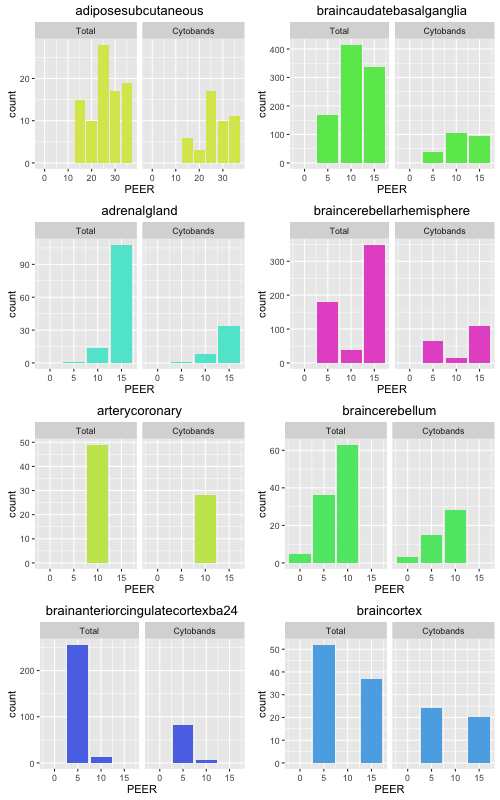

In [2]:
from IPython.display import Image
# proj_dir = '/Users/brian_jo/Desktop/Project/RNAseq_pipeline/'
Image(filename = proj_dir+'Analysis/Figures/trans_list_comparison/PEER_increments_1.png', width=500)

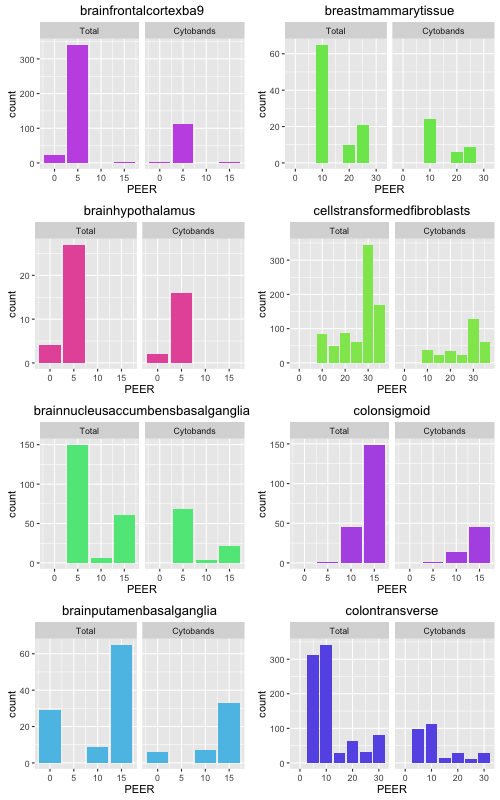

In [3]:
Image(filename = proj_dir+'Analysis/Figures/trans_list_comparison/PEER_increments_2.png', width=500)

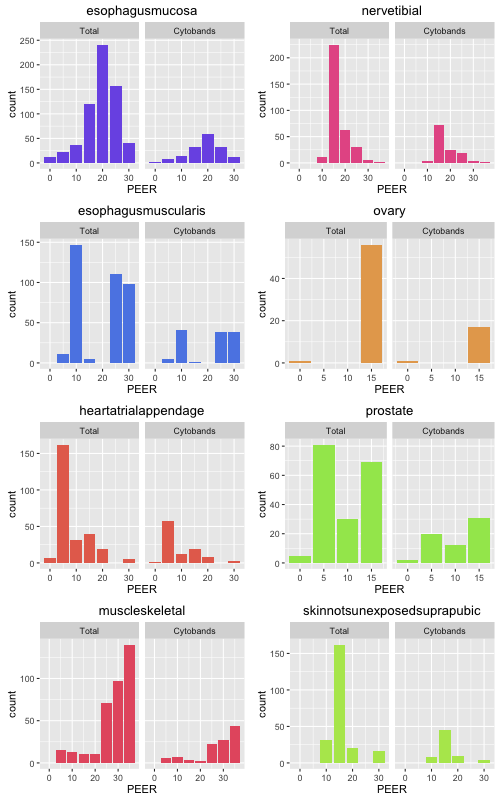

In [4]:
Image(filename = proj_dir+'Analysis/Figures/trans_list_comparison/PEER_increments_3.png', width=500)

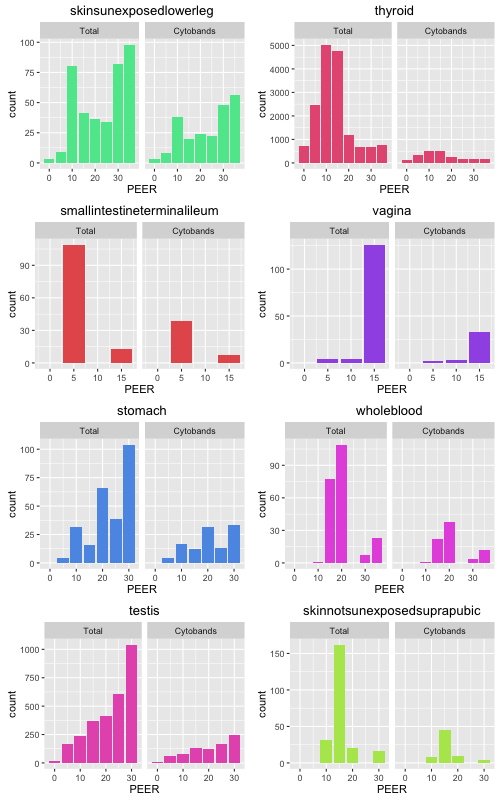

In [5]:
Image(filename = proj_dir+'Analysis/Figures/trans_list_comparison/PEER_increments_4.png', width=500)

### These figures show the number of trans-eQTL pairs, and the number of different loci (in terms of UCSC cytobands - refer to https://www.biostars.org/p/4355/ ) that have hits at FDR 0.5 for each tissue, with PEER factor increments of 5.

### I think with this we are able to infer a more consistent behavior across tissues - an 'inverted U-shape', where the number of trans hits increase, and then decrease (particularly visible in esophagus (mucosa), nerve (tibial) and thyroid examples.

### This result makes more sense - one interpretation may be that when it comes to trans, correcting for broad effects in expression first increases power by removing technical, environmental, and other confounding effects, but then starts removing real biological broad-sense signal.

### Therefore, given the PEER optimization procedure, it would make sense that the number of 'optimal' PEER factors for trans tends to be less than the number of PEER factors actually used, although we see counter-examples of this such as testis, where we don't see a drop-off yet.

### 3.2 Association mapping with Genotype PCs and PEER factors

In [ ]:
%%bash

# MatrixEQTL step
python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_PEER_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/covariates/ \
_Analysis.covariates.txt /Output/trans-mapping/gtex/MatrixEQTL/cov_association/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/cov_association/ \
trans_matrix_eqtl_PEER.R 2.5e8

# FDR control step
python $proj/Scripts/eqtls/trans/gtex/MatrixEQTL_FDR_control_wrapper.py \
/Output/trans-mapping/gtex/MatrixEQTL/cov_association/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/cov_association/ \
cov_association MatrixEQTL_FDR_control_cov.R all

### 3.3 Intrachromosomal analysis

In [ ]:
%%bash
#mkdir /tigress/BEE/eQTLs/Output/trans-mapping/trans-eQTLs/MatrixEQTL/intrachromosomal

python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper.py \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_v6p_consortium_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
trans_matrix_eqtl_intrachromosomal_final.R 5e6 1 6

python $proj/Scripts/eqtls/trans/gtex/MatrixEQTL_FDR_control_wrapper.py \
/Output/trans-mapping/gtex/MatrixEQTL/intrachromosomal/ \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/intrachromosomal/ \
intrachromosomal MatrixEQTL_FDR_control_intrachromosomal_final.R \
all

python $proj/Scripts/eqtls/trans/gtex/Final_trans_list_wrapper.py \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-PEER-increments/ \
1e5 /Output/trans-mapping/gtex/MatrixEQTL/all-by-all-PEER-increments/tissue_list.txt


### 3.3 Varying the FDR threshold for expanded analysis of trans hits

In [ ]:
%%bash

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all/ 0.30 1e5 all-by-all"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all/ 0.50 1e5 all-by-all"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-1third/ 0.30 1e5 all-by-all-1third"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-1third/ 0.50 1e5 all-by-all-1third"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-2thirds/ 0.30 1e5 all-by-all-2thirds"

/home/daguiar/bin/clusterize -l 24:00:00 -m 24G -c "Rscript /tigress/BEE/RNAseq/Scripts/eqtls/trans/gtex/Final_trans_list_only.R /Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all-2thirds/ 0.50 1e5 all-by-all-2thirds"


### 3.4 AA/EA segregation runs for the trans hits

In [ ]:
%%bash

# Run specific trans- Matrix eqtl runs for these
python $proj/Scripts/eqtls/trans/gtex/matrix_eqtl_wrapper_preset_list.py \
/Output/trans-mapping/gtex/trans-eQTLs/MatrixEQTL/all-by-all/Final_trans_eQTL_list.txt \
/Data/Expression/gtex/hg19/GTEx_phs000424_v6p/normalized/ \
_nonverlapping_certain_autosomes_normalized.txt \
/Output/trans-mapping/gtex/MatrixEQTL/seg_runs_orthogonalize/ \
/Output/joblogs/trans-mapping/gtex/MatrixEQTL/seg_runs_orthogonalize/ \
trans_matrix_eqtl_seg_runs.R 2.5e8 1 all

Number of EA/AA samples for each tissue

<code>
adiposesubcutaneous    250    45
adiposevisceralomentum    160    24
adrenalgland    104    20
arteryaorta    173    22
arterycoronary    98    17
arterytibial    238    42
brainanteriorcingulatecortexba24    66    5
braincaudatebasalganglia    84    13
braincerebellarhemisphere    78    9
braincerebellum    90    11
braincortex    80    15
brainfrontalcortexba9    81    11
brainhippocampus    71    9
brainhypothalamus    73    7
brainnucleusaccumbensbasalganglia    79    11
brainputamenbasalganglia    70    10
breastmammarytissue    154    27
cellsebvtransformedlymphocytes    90    24
cellstransformedfibroblasts    226    43
colonsigmoid    113    10
colontransverse    143    24
esophagusgastroesophagealjunction    111    15
esophagusmucosa    212    27
esophagusmuscularis    189    26
heartatrialappendage    137    21
heartleftventricle    167    20
liver    84    12
lung    242    34
muscleskeletal    305    51
nervetibial    208    44
ovary    69    15
pancreas    125    22
pituitary    75    10
prostate    73    12
skinnotsunexposedsuprapubic    164    30
skinsunexposedlowerleg    257    41
smallintestineterminalileum    65    11
spleen    72    17
stomach    143    25
testis    132    21
thyroid    238    37
uterus    57    12
vagina    66    13
wholeblood    283    50
</code>

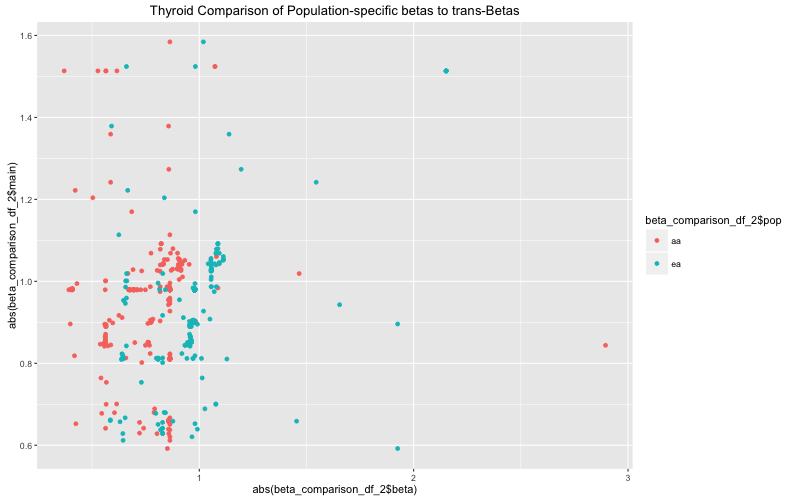

In [23]:
Image(filename = proj_dir+'Analysis/Figures/seg_run_explore/beta_pop_comparison.png', width=800)

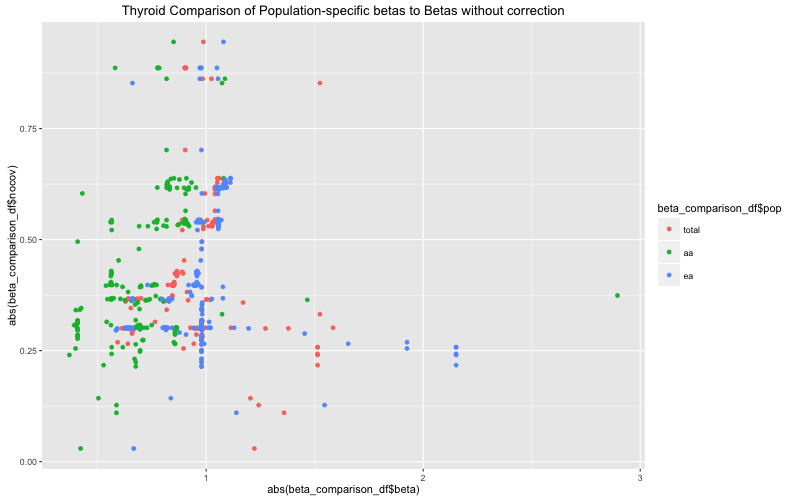

In [24]:
Image(filename = proj_dir+'Analysis/Figures/seg_run_explore/nocov_beta_comparison.png', width=800)

### 3.5 MR - Causal inference framework on GTEx data¶

#### MR_eQTL

In this section, we test an implementation of Mendelian Randomization, For more information about the underlying methodology, refer to this [article by Lawlor et al.](http://research.lunenfeld.ca/gwa_studies/files/file/GWAS/Sheehan_MR/Lawlorsim08.pdf)

In particular, the t-statistic for the strength of causal effect of the gene is calculated as below:

\begin{eqnarray}
t_{MR} &=& \frac {\beta_{MR}} {var(\beta_{MR})} \\
&\text{where:}& \\
\beta_{MR} &=& \frac { \hat\beta_{y,z}} {\hat\beta_{x,z}} \\
var(\beta_{MR}) &=& \sigma^2 (x^T P_z x)^{-1} \\
\sigma^2 &=& \frac {(y - x \beta_{MR})^T (y - x \beta_{MR})} {n - \nu} \\
P_z &=& z(z^Tz)^{-1}z^T \\
\end{eqnarray}

#### Process overview

The pipeline proceeds in a following fashion:

1. Obtain a subset of gene pairs to test for causal inference (eventually expand to the entire gene pairs), from previous trans-mapping results.
    - Take the 
2. Obtain the best cis variants (within 150kb of the gene, say) for each 'causal' gene.
3. Obtain the following set of expression values:
    - Tissue-specific 'Causal' gene expression, with the covariates regressed out
    - Tissue-specific 'Effect' gene expression, with the covariates regressed out
    - Permuted tissue-specific 'Effect' gene expression, with the covariates regressed out
4. Run quick association tests with the genotypes and the three sets of expression values.
5. Run FDR calibration on the results of these association test statistics.

Below we have some example results from the thyroid MR run:

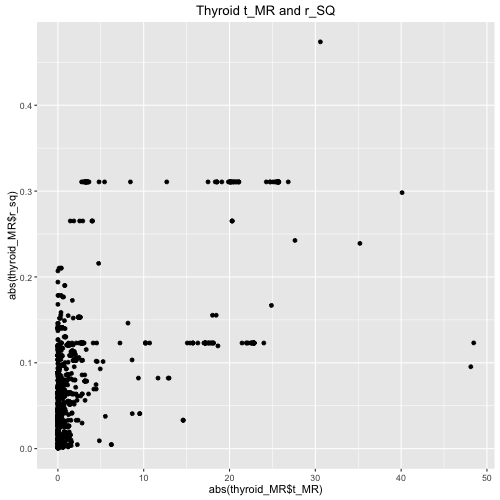

In [17]:
Image(filename = proj_dir+'Analysis/Figures/MR_explore/thyroid_t_MR_r_SQ.png', width=500)

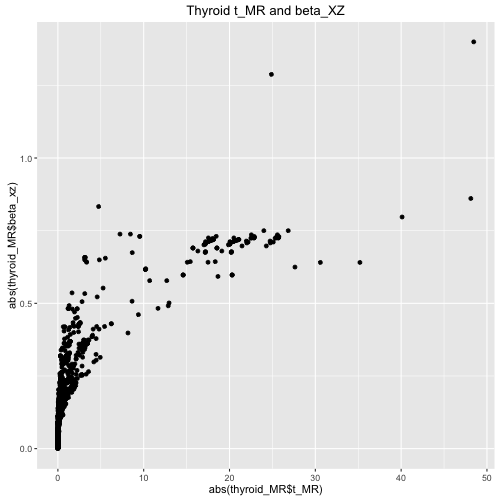

In [18]:
Image(filename = proj_dir+'Analysis/Figures/MR_explore/thyroid_t_MR_beta_XZ.png', width=500)

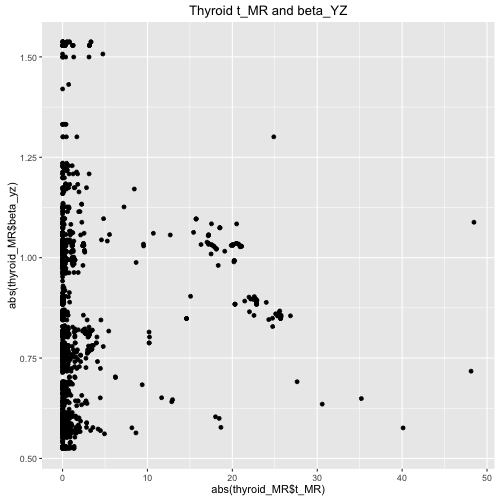

In [19]:
Image(filename = proj_dir+'Analysis/Figures/MR_explore/thyroid_t_MR_beta_YZ.png', width=500)

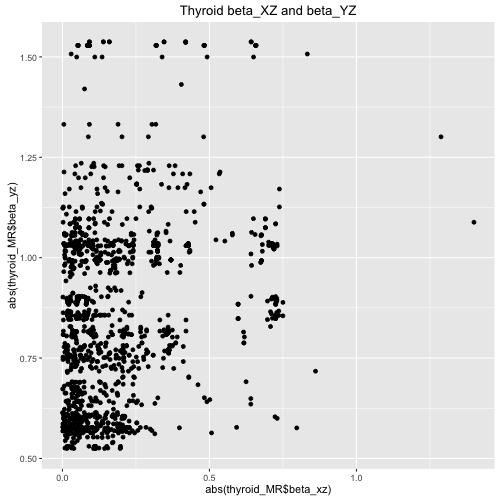

In [21]:
Image(filename = proj_dir+'Analysis/Figures/MR_explore/thyroid_beta_XZ_beta_YZ.png', width=500)

<code>
snp	cis_gene	beta_xz	trans_gene	beta_yz	r_sq	beta_yz_perm	r_sq_perm	t_MR	t_MR_perm	identifier	FDR
rs586670	ENSG00000187010.14	-1.39972102906225	ENSG00000196460.8	-1.08820310812327	0.123204259008573	-0.459853680749444	0.0866702187567312	48.4594756585886	35.7202278786737	rs586670_ENSG00000196460.8	0.0176991150442478
rs722732	ENSG00000135773.8	-0.860782824210931	ENSG00000136936.6	0.717258482700486	-0.0954178811954364	-0.0551829308173652	0.0871552733257626	-48.1173789169377	10.5274148986081	rs722732_ENSG00000136936.6	0.0176991150442478
rs13389834	ENSG00000030419.12	0.797014590220864	ENSG00000156931.11	-0.576038503369134	-0.298179709622641	-0.054055575253409	0.0573533431119271	-40.111893498217	-3.89140888610564	rs13389834_ENSG00000156931.11	0.0176991150442478
rs3796407	ENSG00000109819.4	-0.640677980029958	ENSG00000110955.4	-0.649120968655599	0.239095267271181	0.133843440190431	0.0685883031381548	35.1949695778427	-25.1443442659724	rs3796407_ENSG00000110955.4	0.0176991150442478
rs3796407	ENSG00000109819.4	-0.640677980029958	ENSG00000197444.5	-0.635199084004367	0.473852523245919	0.0285526748542323	0.108105428220378	30.5864507989194	-1.30456956267077	rs3796407_ENSG00000197444.5	0.0176991150442478
rs137910	ENSG00000073146.11	0.624706418372379	ENSG00000138593.4	-0.691032021777769	-0.242519835303737	0.00214163924220295	0.0162402166586689	-27.6277178210408	0.5460411753174	rs137910_ENSG00000138593.4	0.0176991150442478
rs12341377	ENSG00000136932.9	0.749939947213716	ENSG00000112379.8	-0.855207199683445	-0.310709243262689	0.0559270846607506	0.0998800500967066	-26.843522720074	1.97308510834735	rs12341377_ENSG00000112379.8	0.0176991150442478
rs3758251	ENSG00000136932.9	0.729606783226453	ENSG00000112379.8	-0.856067710878542	-0.310709243262689	0.0419065174005295	0.0998800500967066	-25.7505586369476	1.44166718869684	rs3758251_ENSG00000112379.8	0.0176991150442478
rs12348304	ENSG00000136932.9	0.72692550824037	ENSG00000112379.8	-0.852319132255126	-0.310709243262689	0.0448937250525742	0.0998800500967066	-25.7095837151686	1.54856270465442	rs12348304_ENSG00000112379.8	0.0176991150442478
rs894673	ENSG00000136932.9	0.727259284856328	ENSG00000112379.8	-0.853601545036098	-0.310709243262689	0.0431563023364951	0.0998800500967066	-25.7079026318137	1.48705645898907	rs894673_ENSG00000112379.8	0.0176991150442478
rs10818133	ENSG00000136932.9	0.726491310272588	ENSG00000112379.8	-0.851041813447799	-0.310709243262689	0.0463825903154141	0.0998800500967066	-25.7058369540448	1.60137657333878	rs10818133_ENSG00000112379.8	0.0176991150442478
rs10046805	ENSG00000136932.9	0.727413266774262	ENSG00000112379.8	-0.855243228640399	-0.310709243262689	0.0402830245621252	0.0998800500967066	-25.6911889582278	1.3856292191761	rs10046805_ENSG00000112379.8	0.0176991150442478
rs3758249	ENSG00000136932.9	0.727400576765852	ENSG00000112379.8	-0.855387511897794	-0.310709243262689	0.039968218236296	0.0998800500967066	-25.6883228769363	1.37453812805124	rs3758249_ENSG00000112379.8	0.0176991150442478
rs12348691	ENSG00000136932.9	0.72537636409415	ENSG00000112379.8	-0.848362336922475	-0.310709243262689	0.0490210517062554	0.0998800500967066	-25.6871017667002	1.69521645766936	rs12348691_ENSG00000112379.8	0.0176991150442478
rs13288000	ENSG00000136932.9	0.72537636409415	ENSG00000112379.8	-0.848362336922475	-0.310709243262689	0.0490210517062554	0.0998800500967066	-25.6871017667002	1.69521645766936	rs13288000_ENSG00000112379.8	0.0176991150442478
rs7873389	ENSG00000136932.9	0.72537636409415	ENSG00000112379.8	-0.848362336922475	-0.310709243262689	0.0490210517062554	0.0998800500967066	-25.6871017667002	1.69521645766936	rs7873389_ENSG00000112379.8	0.0176991150442478
rs3758248	ENSG00000136932.9	0.727344238060178	ENSG00000112379.8	-0.855715652696867	-0.310709243262689	0.0391869977711811	0.0998800500967066	-25.6803405814562	1.34703286087243	rs3758248_ENSG00000112379.8	0.0176991150442478
rs1443434	ENSG00000136932.9	0.726153063747062	ENSG00000112379.8	-0.856827452446666	-0.310709243262689	0.0341643328470045	0.0998800500967066	-25.6000005177965	1.17080953128748	rs1443434_ENSG00000112379.8	0.0176991150442478
rs1443435	ENSG00000136932.9	0.726153063747062	ENSG00000112379.8	-0.856827452446666	-0.310709243262689	0.0341643328470045	0.0998800500967066	-25.6000005177965	1.17080953128748	rs1443435_ENSG00000112379.8	0.0176991150442478
</code>

It is encouraging to see that at the top entries we see C9orf156 and ARFGEF3 (TMEM253 follows shortly after as well). There are also some trans pairs at the top that we haven't looked into - and may be interesting.